# Orchestrating Jobs with Amazon SageMaker Model Building Pipelines

Amazon SageMaker Model Building Pipelines offers machine learning (ML) application developers and operations engineers the ability to orchestrate SageMaker jobs and author reproducible ML pipelines.

## Notebook Overview

This notebook shows how to:

* Define a set of Pipeline parameters that can be used to parametrize a SageMaker Pipeline.

* Define a Training step that trains a model on the preprocessed train data set.

* Define a model evaluation step and check model evaluation.

* Define a Register Model step that creates a model package from the estimator and model 
artifacts used to train the model, if model evaluation is succcessful.



## Pipelines Instance
A SageMaker Pipeline instance is composed of three components:
    1. Name
    2. Parameters
    3. Steps

## Initial set up

In [ ]:
!pip install -U sagemaker

Upload the data into the default bucket. You can select your own data set for the `input_data_uri` as is appropriate.

In [1]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.workflow.pipeline_context import PipelineSession
pipeline_session = PipelineSession()
role=sagemaker.get_execution_role()

bucket = 'image-classification-workshop'
training_data_uri="s3://{}".format(bucket)
test_data_uri=training_data_uri
print(training_data_uri)
print(test_data_uri)

s3://image-classification-workshop
s3://image-classification-workshop


### Define Parameters to Parametrize Pipeline Execution

Define Pipeline parameters that you can use to parametrize the pipeline. Parameters enable custom pipeline executions and schedules without having to modify the Pipeline definition.

The supported parameter types include:

* `ParameterString` - represents a `str` Python type
* `ParameterInteger` - represents an `int` Python type
* `ParameterFloat` - represents a `float` Python type

These parameters support providing a default value, which can be overridden on pipeline execution. The default value specified should be an instance of the type of the parameter.

The parameters defined in this workflow include:

* `processing_instance_type` - The `ml.*` instance type of the processing job.
* `processing_instance_count` - The instance count of the processing job.
* `training_instance_type` - The `ml.*` instance type of the training job.
* `model_approval_status` - What approval status to register the trained model with for CI/CD purposes ( "PendingManualApproval" is the default).
* `input_data` - The S3 bucket URI location of the input data

In [2]:
# Define pipeline parameters
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=training_data_uri,
)

processing_instance_type ="ml.m5.4xlarge"

If you need a processing step, use the processor instance to construct a `ProcessingStep`, along with the input and output channels, and the code that will be executed when the pipeline invokes pipeline execution. This is similar to a processor instance's `run` method in the Python SDK.

In [ ]:
# from sagemaker.processing import ProcessingInput, ProcessingOutput
# from sagemaker.workflow.steps import ProcessingStep

# job_args = sklearn_processor.run(
#     inputs=[
#       ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  
#     ],
#     outputs=[
#         ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
#         ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
#         ProcessingOutput(output_name="test", source="/opt/ml/processing/test")
#     ],
#     code="marketing/preprocessing.py",
# )

# step_process = ProcessingStep(
#     name="MarketingProcess",
#     step_args = job_args    
# )

### Define a Training Step to Train a Model

Configure an Estimator for Pytorch and the input dataset. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later.

The model path where the models from training will be saved is also specified.

Note the `training_instance_type` parameter may be used in multiple places in the pipeline. In this case, the `training_instance_type` is passed into the estimator.

In [3]:
#from sagemaker.estimator import Estimator

model_path = f"s3://{bucket}/ImageClassification"
training_instance_type = "ml.p3.2xlarge"

pytorch_estimator = PyTorch(
    sagemaker_session=pipeline_session,
    role=sagemaker.get_execution_role(),
    instance_type="ml.p3.2xlarge",
    instance_count=1,
    framework_version="1.8.0",
    py_version="py3",
    entry_point="ptModelCode.py",
)

Finally, use the estimator instance to construct a `TrainingStep` as well as the `properties` of the prior `ProcessingStep` used as input in the `TrainingStep` inputs and the code that's executed when the pipeline invokes the pipeline execution. This is similar to an estimator's `fit` method in the Python SDK.

Pass in the `S3Uri` of the `"train_data"` output channel to the `TrainingStep`. Also, use the other `"test_data"` output channel for model evaluation in the pipeline. The `properties` attribute of a Pipeline step matches the object model of the corresponding response of a describe call. These properties can be referenced as placeholder values and are resolved at runtime. For example, the `ProcessingStep` `properties` attribute matches the object model of the [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response object.

In [4]:
%cd /home/ec2-user/SageMaker/sageMakerWorkshop/MLOps/Pytorch

/home/ec2-user/SageMaker/sageMakerWorkshop/MLOps/Pytorch


In [5]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import Model
from sagemaker.workflow.steps import (
    ProcessingStep,
    TrainingStep,
    CreateModelStep,
    TransformStep
)


step_train = TrainingStep(
    name="ImageClassificationTrainingStep",
    step_args=pytorch_estimator.fit(
        inputs=TrainingInput(s3_data=training_data_uri),
    ),
    description="Image classification training step"
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:233: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Define an evaluation step

In [6]:
from sagemaker.workflow.properties import PropertyFile
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker.workflow.steps import ProcessingStep

base_job_prefix="ImageClassification",
region = 'us-east-1'

image_uri_processing = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=processing_instance_type,
)

script_eval = ScriptProcessor(
    image_uri=image_uri_processing,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    sagemaker_session=pipeline_session,
    role=role,
)
step_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=test_data_uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="evaluate.py",
)
evaluation_report = PropertyFile(
    name="ImageClassificationEvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)
step_eval = ProcessingStep(
    name="EvaluateImageClassificationModel",
    step_args=step_args,
    property_files=[evaluation_report],
)


Job Name:  sagemaker-scikit-learn-2022-09-05-13-02-20-253
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': <sagemaker.workflow.properties.Properties object at 0x7f269546ca60>, 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://image-classification-workshop', 'LocalPath': '/opt/ml/processing/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-462768798410/sagemaker-scikit-learn-2022-09-05-13-02-20-253/input/code/evaluate.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'

### Define a ModelStep to register the model in the Model Registry

Use the output of the training step to create a model and register it in the Model Regitry. Using the `ModelStep` you can create a model package. A model package is a reusable model artifacts abstraction that packages all ingredients required for inference. Primarily, it consists of an inference specification that defines the inference image to use along with an optional model weights location.

A model package group is a collection of model packages. A model package group can be created for a specific ML business problem, and new versions of the model packages can be added to it. Typically, customers are expected to create a ModelPackageGroup for a SageMaker Pipeline so that model package versions can be added to the group for every SageMaker Pipeline run.

Specifically, create a Model using the SageMaker SDK `Model` class and call the `.register()` method. Pass the outputs of the `.register()` method to the `ModelStep` so that it can be run as a pipeline step. 

Note that the specific model package group name provided in this notebook can be used in the model registry and CI/CD work with SageMaker Projects.

In [7]:
image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    version="1.8.0",
    py_version="py3",
    image_scope="inference",
    instance_type=training_instance_type
)
image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.8.0-gpu-py3'

In [8]:
# register model step that will be conditionally executed

from sagemaker.pytorch.model import PyTorchModel
from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)

pipeline_session = PipelineSession()

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json"
    )
)
Pytorch_Model = PyTorchModel(
    entry_point="ptInfCode.py",
    role=role,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    framework_version="1.8.0",
    py_version="py3",
    sagemaker_session=pipeline_session
)

from sagemaker.workflow.model_step import ModelStep
from sagemaker import PipelineModel

pipeline_model = PipelineModel(
    models=[Pytorch_Model],
    role=role, 
    sagemaker_session=pipeline_session,
)

register_model_step_args = pipeline_model.register(
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.m5.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name='ImageClassificationPytorch',
)

step_register = ModelStep(
   name="ImageClassificationPytorchRegisterModel",
   step_args=register_model_step_args,
)

### Condition step for evaluating model quality and branching execution


In [9]:
from sagemaker.workflow.condition_step import (ConditionStep)
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.functions import (JsonGet)

cond_lte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="Test_set_metrics.accuracy"
    ),
    right=0.001,
)
step_cond = ConditionStep(
    name="CheckAccuracyEvaluation",
    conditions=[cond_lte],
    if_steps=[step_register],
    else_steps=[],
)

### Define a Pipeline of Parameters, Steps, and Conditions

In this section, combine the steps into a Pipeline so it can be executed.

A pipeline requires a `name`, `parameters`, and `steps`. Names must be unique within an `(account, region)` pair.

Note:

* All of the parameters used in the definitions must be present.
* Steps passed into the pipeline do not have to be listed in the order of execution. The SageMaker Pipeline service resolves the _data dependency_ DAG as steps for the execution to complete.
* Steps must be unique to across the pipeline step list and all condition step if/else lists.

In [10]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = f"PytorchImgClassify"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type, 
        processing_instance_count,
        training_instance_type,
        model_approval_status,
        input_data,
    ],
    steps=[step_train, step_eval, step_cond])

#### (Optional) Examining the pipeline definition

The JSON of the pipeline definition can be examined to confirm the pipeline is well-defined and the parameters and step properties resolve correctly.

### Submit the pipeline to SageMaker and start execution

Submit the pipeline definition to the Pipeline service. The role passed in will be used by the Pipeline service to create all the jobs defined in the steps.

In [11]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:462768798410:pipeline/pytorchimgclassify',
 'ResponseMetadata': {'RequestId': '6c5a1a13-d033-47ce-b099-b11cb7153839',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6c5a1a13-d033-47ce-b099-b11cb7153839',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Mon, 05 Sep 2022 13:03:15 GMT'},
  'RetryAttempts': 0}}

Start the pipeline and accept all of the default parameters.

In [12]:
execution = pipeline.start()

### Pipeline Operations: Examining and Waiting for Pipeline Execution

Describe the pipeline execution.

In [13]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:462768798410:pipeline/pytorchimgclassify',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:462768798410:pipeline/pytorchimgclassify/execution/t3k8qsvqtzyx',
 'PipelineExecutionDisplayName': 'execution-1662382997034',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'pytorchimgclassify',
  'TrialName': 't3k8qsvqtzyx'},
 'CreationTime': datetime.datetime(2022, 9, 5, 13, 3, 16, 908000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 9, 5, 13, 3, 16, 908000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedBy': {},
 'ResponseMetadata': {'RequestId': 'abd86d20-1160-433d-abe2-312aaf7502f3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'abd86d20-1160-433d-abe2-312aaf7502f3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '495',
   'date': 'Mon, 05 Sep 2022 13:03:53 GMT'},
  'RetryAttempts': 0}}

In [14]:
execution.wait()

List the steps in the execution. These are the steps in the pipeline that have been resolved by the step executor service.

In [ ]:
execution.list_steps()

Once the pipeline is completed, you should see the pipeline flow when you open your pipeline in the studio.

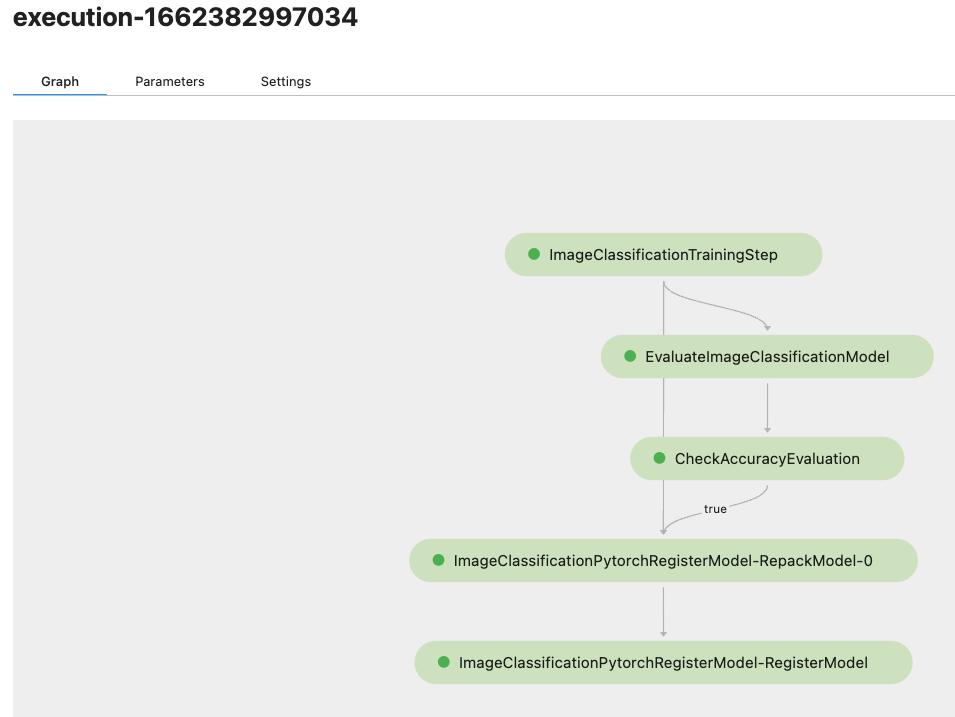

Next, go to Model Registry under SageMaker resources. Find the model group name that you used and double click on it. You should see that there is a model registered with status **pending** 

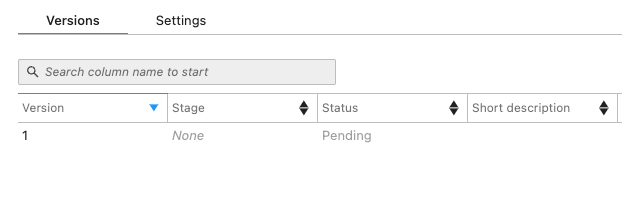

Right click on the row and click on `Update model version status...`. Change the status to **Approved** and click on `Update status`

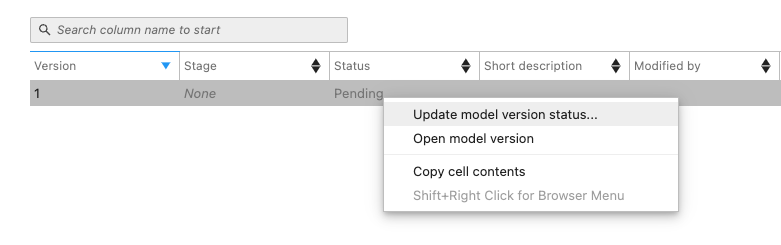

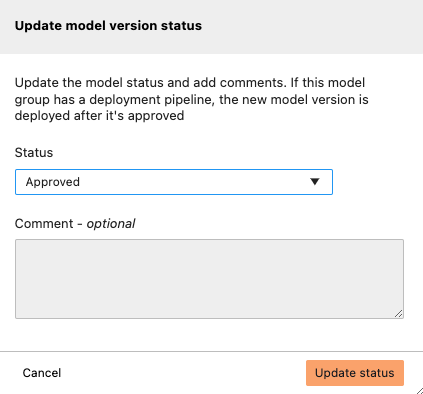

### Using SageMaker Project Template for model deployment

SageMaker Projects  help organizations set up and standardize developer environments for data scientists and CI/CD systems for MLOps engineers. Projects also help organizations set up dependency management, code repository management, build reproducibility, and artifact sharing.

With SageMaker Projects, MLOps engineers and organization admins can define their own templates or use SageMaker-provided templates. The SageMaker-provided templates bootstrap the ML workflow with source version control, automated ML pipelines, and a set of code to quickly start iterating over ML use cases.

Today, we will use a SageMaker Project template for Model deployment.

Navigate to the SageMaker Project Resource

Click on `Create Project`. You will see a range of SageMaker project templates to select from.

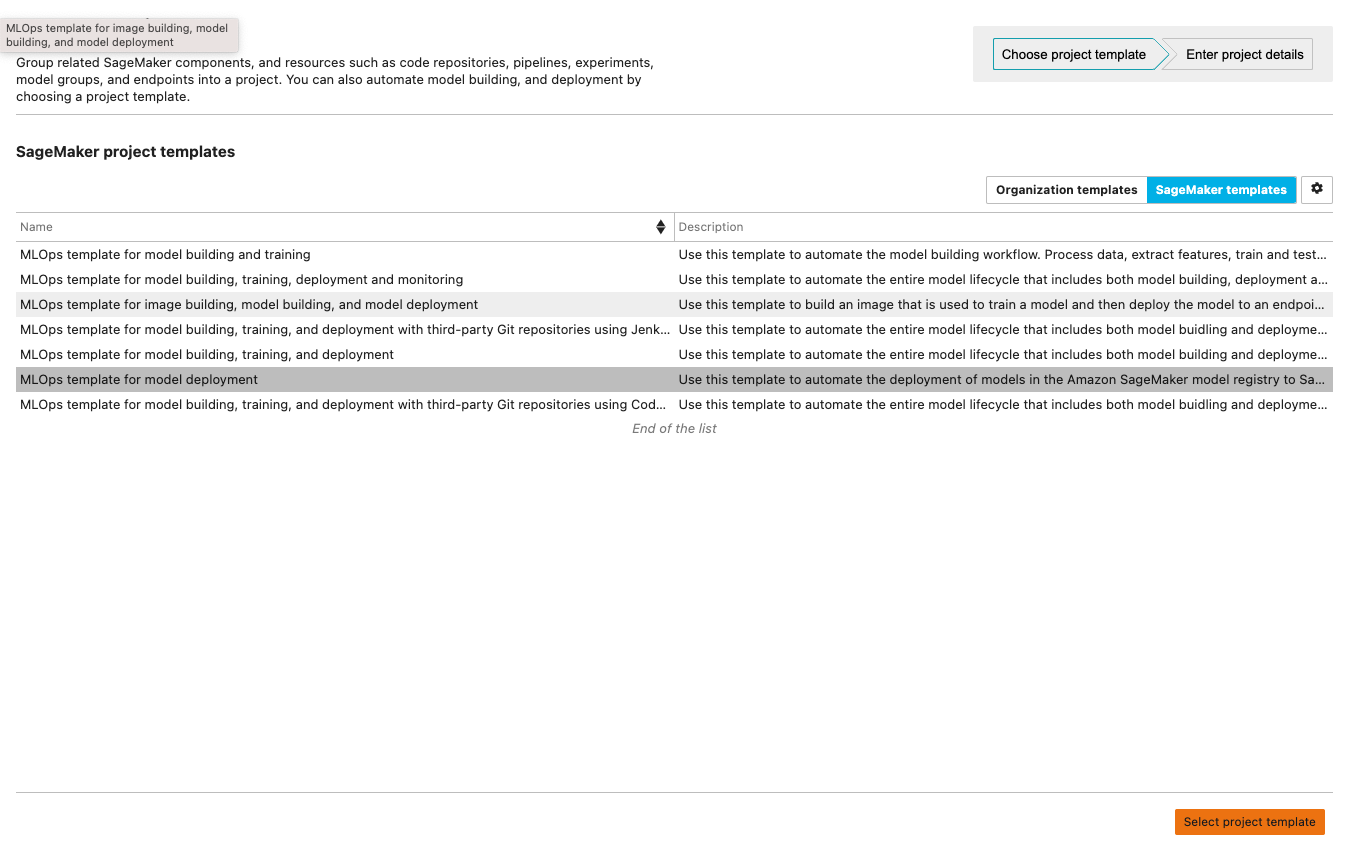

Select the `MLOps template for model deployment` and click on `Select template`

Give a name to the project, put the model_package_group_name (which is defined in the model register step) and click on `Create project`

Once the project is created, soon after, you will see that staging end-point is being created. You can verify it from the Endpoints in Studio or from SageMaker console under endpoints.

You can do necessary testing on the staging endpoint to make sure that it is ready to move to PROD.

Next step is for the ML Ops lead or Dev Ops lead to approve the staging endpoint in CodePipeline. You can do so by clicking on `Review` and then `Approve`. Once it is approved, deployment of production endpoint will start

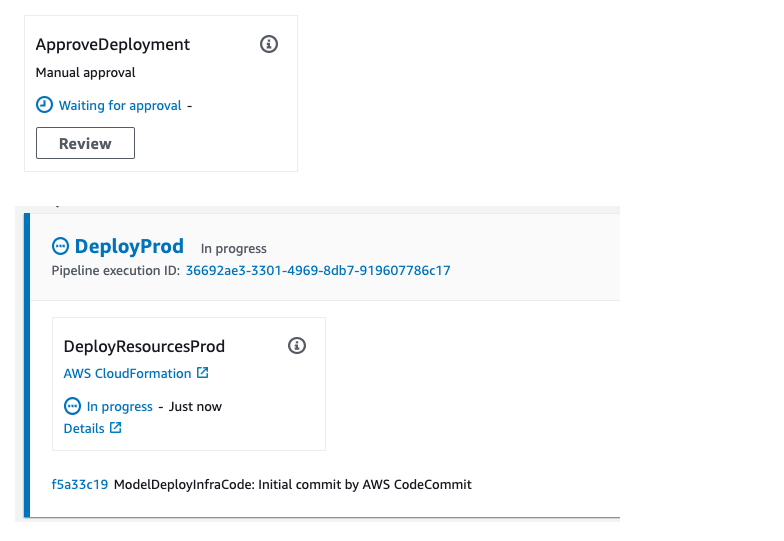

Once, prod deployment is complete, the production endpoint will be created

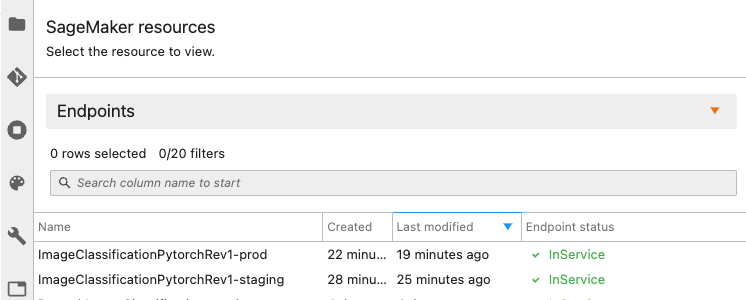

## Optional

### Lineage

Review the lineage of the artifacts generated by the pipeline.

In [ ]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

### Parametrized Executions

You can run additional executions of the pipeline and specify different pipeline parameters. The parameters argument is a dictionary containing parameter names, and where the values are used to override the defaults values.

Based on the performance of the model, you might want to kick off another pipeline execution on a compute-optimized instance type and set the model approval status to "Approved" automatically. This means that the model package version generated by the `RegisterModel` step is automatically ready for deployment through CI/CD pipelines, such as with SageMaker Projects.

In [ ]:
execution = pipeline.start(
    parameters=dict(
        ProcessingInstanceType="ml.c5.xlarge",
        ModelApprovalStatus="Approved",
    )
)

In [ ]:
execution.wait()

In [ ]:
execution.list_steps()